<a href="https://colab.research.google.com/github/escape-capstone-design/NLP/blob/seungeun/finetuning/kosimcse_roberta_wholedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install sentence_transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.8 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_tran

In [ ]:
import random
import math
import numpy as np
import logging
from datetime import datetime
import pandas as pd
import os
import csv
from typing import List, Union
from tqdm.autonotebook import trange

import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer, models, LoggingHandler, losses, util, SentencesDataset
from sentence_transformers.evaluation import SentenceEvaluator, TripletEvaluator
from sentence_transformers.readers import InputExample
from sentence_transformers.datasets import NoDuplicatesDataLoader

<ipython-input-3-b7ba02badc07>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


# dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/종설/dataset.csv')
data

,sentence1,sentence2,gold_label
0,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자가 먹을 것이 없어 죽게되고 분해자도 소비자가 다 죽어 소비자...,entailment
1,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 생태계에 없으면 소비자와 분해자가 먹을것을 못먹는다.못먹는 소비자와 분해자...,entailment
2,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 있지 않으면 생산자를 먹는 동물도 그 동물을 먹는 동물도 굶게 되어 생태계...,entailment
3,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자는 소비자와 분해자들에게 영양을 제공한다. 만약 생산자가 없다면 소비자는 영양...,entailment
4,"생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계...",생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다,entailment
...,...,...,...
9959,부력에 의해 배를 띄울 수 있다.,물이 힘이있어서,contradiction
9960,부력에 의해 배를 띄울 수 있다.,파도를 이용하여 뜨게 하는것 같다,contradiction
9961,부력에 의해 배를 띄울 수 있다.,물체를 띄우는 힘인 부력을 활용한 것이다.,entailment
9962,부력에 의해 배를 띄울 수 있다.,배는 부력의 원리로 뜨기 때문에 물을 사용하면 쉽게 이동시킬 수 있다.,entailment


In [ ]:
# Anchor 문장 중복 O

def make_nli_triplet_input_example(dataset):
    # transform to Triplet format
    train_data = {}

    def add_to_samples(sent1, sent2, label):
        if sent1 not in train_data:
            train_data[sent1] = {'contradiction': set(), 'entailment': set(), 'neutral': set()}
        train_data[sent1][label].add(sent2)

    for i, row in dataset.iterrows():
        sent1 = str(row['sentence1']).strip()
        sent2 = str(row['sentence2']).strip()
        label = row['gold_label'].strip()

        add_to_samples(sent1, sent2, label)

    # transform to InputExamples
    input_examples = []
    for sent1, others in train_data.items():
        if len(others['entailment']) > 0 and len(others['contradiction']) > 0:
            entailment_list = list(others['entailment'])
            contradiction_list = list(others['contradiction'])

            # Shuffle the lists to randomize the selection
            random.shuffle(entailment_list)
            random.shuffle(contradiction_list)

            # Use the same anchor for multiple triplets
            anchor = sent1

            for _ in range(3):  # Adjust the number of triplets as needed
                ent = random.choice(entailment_list)
                con = random.choice(contradiction_list)

                input_examples.append(InputExample(texts=[anchor, ent, con]))

    return input_examples

In [ ]:
dataset = make_nli_triplet_input_example(data)
dataset[0].texts

['생산자가 없어진다면 생산자를 먹는 소비자는 먹이가 없어서 죽게 되고, 그 다음 단계의 소비자도 먹이가 없어서 죽게 되어 생태계의 균형이 깨진다.',
 '생산자가 없으면 소비자와 분해자는 독립영양을 못하기 때문에 죽게되기 때문이다',
 '안배워서 몰라요']

In [ ]:
print(f'dataset: {len(dataset)}')

dataset: 1296


In [ ]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - validation_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(valid_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 1036
Validation Data Size : 259
Testing Data Size : 1


#evaluator

In [ ]:
# Evaluator by train
train_evaluator = TripletEvaluator.from_input_examples(
    train_dataset,
    name="train-evaluator",
)

# Evaluator by validation
valid_evaluator = TripletEvaluator.from_input_examples(
    valid_dataset,
    name="valid-evaluator",
)

# Evaluator by test
test_evaluator = TripletEvaluator.from_input_examples(
    test_dataset,
    name="test-evaluator",
)

In [ ]:
# get loss value

logger = logging.getLogger(__name__)

class LossEvaluator(SentenceEvaluator):

    def __init__(self, loader, loss_model: nn.Module = None, name: str = '', log_dir: str = None,
                 show_progress_bar: bool = False, write_csv: bool = True):

        """
        Evaluate a model based on the loss function.
        The returned score is loss value.
        The results are written in a CSV and Tensorboard logs.
        :param loader: Data loader object
        :param loss_model: loss module object
        :param name: Name for the output
        :param log_dir: path for tensorboard logs
        :param show_progress_bar: If true, prints a progress bar
        :param write_csv: Write results to a CSV file
        """

        self.loader = loader
        self.write_csv = write_csv
        self.logs_writer = SummaryWriter(log_dir=log_dir)
        self.name = name
        self.loss_model = loss_model

        # move model to gpu:  lidija-jovanovska
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        loss_model.to(self.device)

        if show_progress_bar is None:
            show_progress_bar = (
                    logger.getEffectiveLevel() == logging.INFO or logger.getEffectiveLevel() == logging.DEBUG)
        self.show_progress_bar = show_progress_bar

        self.csv_file = "loss_evaluation" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "loss"]

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:

        self.loss_model.eval()

        loss_value = 0
        self.loader.collate_fn = model.smart_batching_collate
        num_batches = len(self.loader)
        data_iterator = iter(self.loader)

        with torch.no_grad():
          for _ in trange(num_batches, desc="Iteration", smoothing=0.05, disable=not self.show_progress_bar):
              sentence_features, labels = next(data_iterator)
              # move data to gpu
              for i in range(0, len(sentence_features)):
                  for key, value in sentence_features[i].items():
                      sentence_features[i][key] = sentence_features[i][key].to(self.device)
              labels = labels.to(self.device)
              loss_value += self.loss_model(sentence_features, labels).item()

        final_loss = loss_value / num_batches
        if output_path is not None and self.write_csv:

            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)

            with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, final_loss])

            # ...log the running loss
            self.logs_writer.add_scalar('val_loss',
                                        final_loss,
                                        steps)

        self.loss_model.zero_grad()
        self.loss_model.train()

        return final_loss

# model

In [ ]:
# Load Embedding Model
embedding_model = models.Transformer(
    model_name_or_path="BM-K/KoSimCSE-roberta-multitask",
    max_seq_length=900,
    do_lower_case=True
)

# Only use Mean Pooling -> Pooling all token embedding vectors of sentence.
pooling_model = models.Pooling(
    embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

model = SentenceTransformer(modules=[embedding_model, pooling_model])

In [ ]:
# config
num_epochs = 10
batch_size = 16

In [ ]:
train_dataset = SentencesDataset(train_dataset, model=model)

# Train / Valid Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# train model
pretrained_model_name = "BM-K/KoSimCSE-roberta-multitask"
model_save_path = 'output/'+pretrained_model_name.replace("/", "-")+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Use TripletLoss
loss_func = losses.TripletLoss(model)

# warmup steps
warmup_steps = math.ceil(len(train_dataset) * num_epochs / batch_size * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

epochs = []
train_list = []
valid_list = []
test_list = []
train_loss_history = []
valid_loss_history = []

# loss evaluator
train_loss_evaluator = LossEvaluator(train_dataloader, loss_model=loss_func, log_dir='logs/', name='train')
valid_loss_evaluator = LossEvaluator(valid_dataloader, loss_model=loss_func, log_dir='logs/', name='valid')

# Training
for epoch in range(num_epochs):
    print(f'{epoch} epoch')
    epochs.append(epoch)
    model.fit(
              train_objectives=[(train_dataloader, loss_func)],
              evaluator=valid_evaluator,
              epochs=1,
              evaluation_steps=int(len(train_dataloader)*0.1),
              warmup_steps=warmup_steps,
              output_path=model_save_path,
              use_amp=False       #Set to True, if your GPU supports FP16 operations
    )

    train = train_evaluator(model)
    train_list.append(train)
    print(f'train => {train}')

    valid = valid_evaluator(model)
    valid_list.append(valid)
    print(f'valid => {valid}')

    # todo: test 데이터 사용 시 주석 해제
    # test = test_evaluator(model)
    # test_list.append(test)
    # print(f'test => {test}')

    train_loss = train_loss_evaluator(model)
    train_loss_history.append(train_loss)
    print(f'train_loss => {train_loss}')

    valid_loss = valid_loss_evaluator(model)
    valid_loss_history.append(valid_loss)
    print(f'valid_loss => {valid_loss}')

0 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9546332046332047
valid => 0.9498069498069498
train_loss => 0.5707266782338802
valid_loss => 0.7022982642931097
1 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9893822393822393
valid => 0.9845559845559846
train_loss => 0.2565627893576255
valid_loss => 0.39633315626312704
2 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9922779922779923
valid => 0.9922779922779923
train_loss => 0.12610055254055905
valid_loss => 0.2193827558966244
3 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9932432432432432
valid => 0.9922779922779923
train_loss => 0.06829212812276987
valid_loss => 0.1700703501701355
4 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9980694980694981
valid => 0.9961389961389961
train_loss => 0.026843975369746868
valid_loss => 0.11170522605671603
5 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9980694980694981
valid => 0.9922779922779923
train_loss => 0.01440141613666828
valid_loss => 0.10114807942334343
6 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 0.9980694980694981
valid => 0.9961389961389961
train_loss => 0.03205951085457435
valid_loss => 0.12080215355929207
7 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 1.0
valid => 1.0
train_loss => 0.013117335851375873
valid_loss => 0.14652557758723989
8 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 1.0
valid => 1.0
train_loss => 0.007168498635292053
valid_loss => 0.08315906454535092
9 epoch


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/65 [00:00<?, ?it/s]

train => 1.0
valid => 0.9961389961389961
train_loss => 0.0012272302921001728
valid_loss => 0.0891171816517325


In [ ]:
# evaluation dev
valid_evaluator(model, output_path=model_save_path)

0.9961389961389961

In [ ]:
# todo: test 데이터 사용 시 주석 해제
# evaluation test
# test_evaluator(model, output_path=model_save_path)

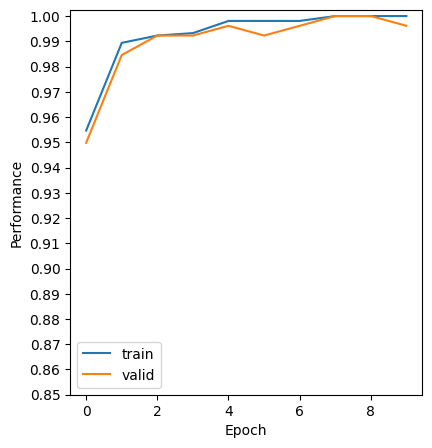

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.legend()
yticks = [i/100 for i in range(85, int(max(train_list)*100)+1)]
plt.yticks(yticks)
plt.show()

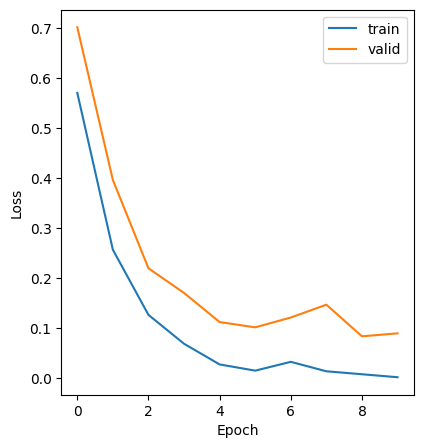

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, train_loss_history, label='train')
plt.plot(epochs, valid_loss_history, label='valid')
plt.legend()
plt.show()

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, util

# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승한다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")

In [ ]:
import torch
from sentence_transformers import SentenceTransformer, util

# 문장을 정의
sentence1 = "주위의 온도가 높아진다."
sentence2 = "온도는 상승하지 않는다."

# 두 문장을 모델로 임베딩
embeddings = model.encode([sentence1, sentence2], convert_to_tensor=True)

# 코사인 유사도 계산
cosine_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])

print(f"첫 번째 문장과 두 번째 문장의 코사인 유사도: {cosine_score.item():.4f}")